<a href="https://colab.research.google.com/github/DiegoLuis62/Ciencias-de-datos---PF/blob/main/Heart_Disease_Cleanse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Carga y exploración inicial del dataset**

In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [78]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = "/content/drive/My Drive/10 semestre/PF-Dataset"
df = pd.read_csv(dataset_path + "/heart_2022_with_nans.csv")
# Link del dataset : https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
print(df.shape)
print("")
df.head()


(445132, 40)



,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,NaN,No,...,NaN,NaN,NaN,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
1,Alabama,Female,Excellent,0.0,0.0,NaN,No,6.0,NaN,No,...,1.60,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,NaN,No,...,1.57,63.50,25.61,No,No,No,No,NaN,No,Yes
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,NaN,No,...,1.65,63.50,23.30,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,NaN,No,...,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      445132 non-null  object 
 1   Sex                        445132 non-null  object 
 2   GeneralHealth              443934 non-null  object 
 3   PhysicalHealthDays         434205 non-null  float64
 4   MentalHealthDays           436065 non-null  float64
 5   LastCheckupTime            436824 non-null  object 
 6   PhysicalActivities         444039 non-null  object 
 7   SleepHours                 439679 non-null  float64
 8   RemovedTeeth               433772 non-null  object 
 9   HadHeartAttack             442067 non-null  object 
 10  HadAngina                  440727 non-null  object 
 11  HadStroke                  443575 non-null  object 
 12  HadAsthma                  443359 non-null  object 
 13  HadSkinCancer              44

# **2. Análisis de valores nulos: cantidad, porcentaje y tipo de datos**

En este análisis, se identifican las columnas que contienen valores nulos dentro del dataset. Se calcula la cantidad y el porcentaje de datos faltantes en cada variable, además de determinar su tipo de dato (numérico o categórico). Esto permite evaluar el impacto de los valores ausentes y definir estrategias adecuadas para la limpieza y el tratamiento de los datos.

In [81]:
missing_values = df.isnull().sum()

# Filtrar solo las columnas con NaN
missing_columns = missing_values[missing_values > 0]

# Obtener los tipos de datos de esas columnas
dtypes = df.dtypes[missing_columns.index]

# Crear un DataFrame con la información
missing_info = pd.DataFrame({
    "Missing Values": missing_columns,
    "Percentage": (missing_columns / len(df)) * 100,
    "Data Type": dtypes
})


missing_info

,Missing Values,Percentage,Data Type
GeneralHealth,1198,0.269134,object
PhysicalHealthDays,10927,2.454777,float64
MentalHealthDays,9067,2.036924,float64
LastCheckupTime,8308,1.866413,object
PhysicalActivities,1093,0.245545,object
SleepHours,5453,1.225030,float64
RemovedTeeth,11360,2.552052,object
HadHeartAttack,3065,0.688560,object
HadAngina,4405,0.989594,object
HadStroke,1557,0.349784,object


In [82]:
for col in df: # Verificar si hay una columna o atributo que no aporte, ejemplo si tiene 1 subnivel, no nos sirve
  print(f"Columna {col}: {df[col].nunique() } subniveles ")

Columna State: 54 subniveles 
Columna Sex: 2 subniveles 
Columna GeneralHealth: 5 subniveles 
Columna PhysicalHealthDays: 31 subniveles 
Columna MentalHealthDays: 31 subniveles 
Columna LastCheckupTime: 4 subniveles 
Columna PhysicalActivities: 2 subniveles 
Columna SleepHours: 24 subniveles 
Columna RemovedTeeth: 4 subniveles 
Columna HadHeartAttack: 2 subniveles 
Columna HadAngina: 2 subniveles 
Columna HadStroke: 2 subniveles 
Columna HadAsthma: 2 subniveles 
Columna HadSkinCancer: 2 subniveles 
Columna HadCOPD: 2 subniveles 
Columna HadDepressiveDisorder: 2 subniveles 
Columna HadKidneyDisease: 2 subniveles 
Columna HadArthritis: 2 subniveles 
Columna HadDiabetes: 4 subniveles 
Columna DeafOrHardOfHearing: 2 subniveles 
Columna BlindOrVisionDifficulty: 2 subniveles 
Columna DifficultyConcentrating: 2 subniveles 
Columna DifficultyWalking: 2 subniveles 
Columna DifficultyDressingBathing: 2 subniveles 
Columna DifficultyErrands: 2 subniveles 
Columna SmokerStatus: 4 subniveles 
Colum

In [83]:
# Verificar cantidad de filas duplicadas en el dataset original
duplicados = df.duplicated().sum()

print(f"Número de filas duplicadas en el dataset original: {duplicados}")
df.drop_duplicates(inplace=True)



Número de filas duplicadas en el dataset original: 157


Acabo de eliminar 157 datos duplicados del dataset original para evitar tener que eliminarlos uno por uno al copiar los demás datasets.

#**3) Limpieza de los Datasets**



#Limpieza de Dataset por Eliminación



In [84]:
df_cleaned = df.dropna()  # Elimina filas con valores nulos
print(f"Filas originales: {df.shape[0]}")
print(f"Filas después de limpieza: {df_cleaned.shape[0]}")



Filas originales: 444975
Filas después de limpieza: 246013


#Limpieza de Dataset Usando Moda, Mediana

In [85]:

from sklearn.impute import SimpleImputer

df_imputado = df.copy()

# Identificar variables categóricas y numéricas
categorical_vars = df_imputado.select_dtypes(include=['object']).columns
binary_vars = [var for var in categorical_vars if df_imputado[var].nunique() == 2]  # Variables binarias
num_vars = df_imputado.select_dtypes(include=['float64']).columns

# Imputación con moda para categóricas y binarias
imputer_moda = SimpleImputer(strategy="most_frequent")
df_imputado[categorical_vars] = imputer_moda.fit_transform(df_imputado[categorical_vars])

# Imputación con mediana para variables numéricas
imputer_mediana = SimpleImputer(strategy="median")
df_imputado[num_vars] = imputer_mediana.fit_transform(df_imputado[num_vars])

# Guardar dataset imputado
df_imputado.to_csv("dataset_imputado.csv", index=False)




In [86]:
print(f"Filas originales: {df.shape[0]}")
print(f"Filas después de imputar: {df_imputado.shape[0]}")

Filas originales: 444975
Filas después de imputar: 444975


# **4) Comparación de columnas numéricas del dataset original, eliminación de datos nulos e imputación.**

**Dataset con datos Originales**

In [87]:

df.describe()


,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,434053.000000,435913.000000,439527.000000,416470.000000,403044.000000,396316.000000
mean,4.349372,4.384164,7.022909,1.702690,83.074632,28.529907
std,8.689968,8.388541,1.502618,0.107178,21.448241,6.554917
min,0.000000,0.000000,1.000000,0.910000,22.680000,12.020000
25%,0.000000,0.000000,6.000000,1.630000,68.040000,24.130000
50%,0.000000,0.000000,7.000000,1.700000,80.740000,27.440000
75%,3.000000,5.000000,8.000000,1.780000,95.250000,31.750000
max,30.000000,30.000000,24.000000,2.410000,292.570000,99.640000


**Dataset con datos nulos eliminados**

In [88]:
df_cleaned.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,246013.000000,246013.000000,246013.000000,246013.000000,246013.000000,246013.000000
mean,4.119055,4.167292,7.021312,1.705150,83.615522,28.668258
std,8.405803,8.102796,1.440698,0.106654,21.323232,6.514005
min,0.000000,0.000000,1.000000,0.910000,28.120000,12.020000
25%,0.000000,0.000000,6.000000,1.630000,68.040000,24.270000
50%,0.000000,0.000000,7.000000,1.700000,81.650000,27.460000
75%,3.000000,4.000000,8.000000,1.780000,95.250000,31.890000
max,30.000000,30.000000,24.000000,2.410000,292.570000,97.650000


**Dataset con datos Imputados**

In [89]:

df_imputado.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,444975.000000,444975.000000,444975.000000,444975.000000,444975.000000,444975.000000
mean,4.242616,4.294879,7.022628,1.702518,82.854634,28.410723
std,8.609002,8.325745,1.493393,0.103690,20.424073,6.195490
min,0.000000,0.000000,1.000000,0.910000,22.680000,12.020000
25%,0.000000,0.000000,6.000000,1.630000,68.040000,24.410000
50%,0.000000,0.000000,7.000000,1.700000,80.740000,27.440000
75%,3.000000,4.000000,8.000000,1.780000,91.630000,31.010000
max,30.000000,30.000000,24.000000,2.410000,292.570000,99.640000


# **Análisis Comparativo de Métodos para el Manejo de Datos Faltantes**

En el presente análisis, se compararon dos estrategias para tratar los datos faltantes en el dataset: la eliminación de registros con valores nulos y la imputación mediante la moda (para datos categóricos) y la mediana (para datos numéricos). A continuación, se presentan los hallazgos clave.

# 1️⃣ Eliminación de Datos Faltantes

Se redujo significativamente la cantidad de datos, pasando de ~434,205 registros a 246,022 en algunas columnas, representando una pérdida aproximada del 43.3% de la información.

La media de variables clave, como el Índice de Masa Corporal (BMI), pasó de 28.53 en el dataset original a 28.67 tras la eliminación de datos, lo que sugiere que los valores eliminados tenían una distribución diferente al conjunto de datos restante.

Se observó una disminución en la dispersión de los datos (medida a través de la desviación estándar), lo que indica una posible pérdida de variabilidad en la muestra.

# 2️⃣ Imputación con Moda y Mediana

Se conservaron 445,132 registros, manteniendo la totalidad de la muestra sin pérdida de información.

La media del BMI fue 28.41, mucho más cercana al valor original (28.53) en comparación con la eliminación de datos.

La desviación estándar disminuyó ligeramente en comparación con el dataset original, pero sin alterar significativamente la variabilidad inherente a los datos.

# 📌 Conclusión

El análisis comparativo evidencia que la eliminación de datos genera una pérdida considerable de información y puede introducir sesgos en la muestra al alterar las estadísticas descriptivas de las variables. En contraste, la imputación con moda y mediana preserva la estructura del dataset y mantiene los valores estadísticos más cercanos a los originales.

Por lo tanto, para evitar la pérdida de información valiosa y minimizar el sesgo en futuros análisis, se recomienda la imputación de valores faltantes en lugar de la eliminación de registros.

# **5) Análisis de datos**

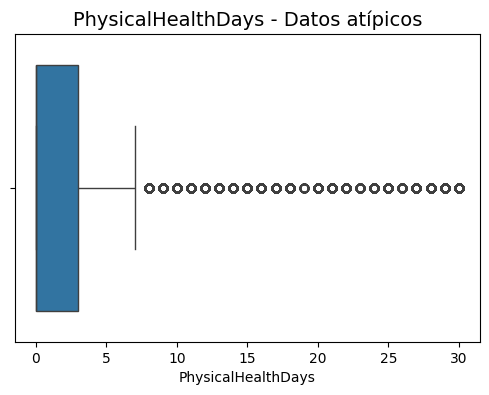

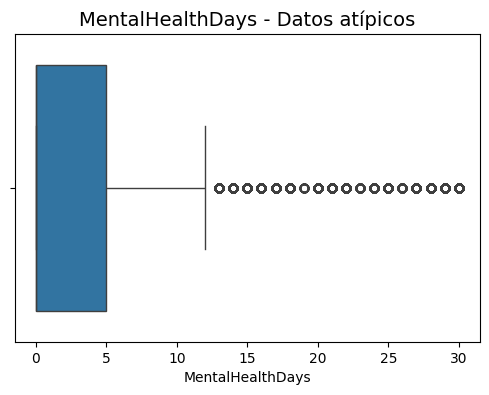

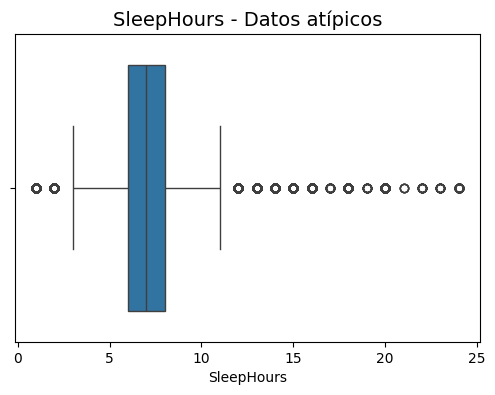

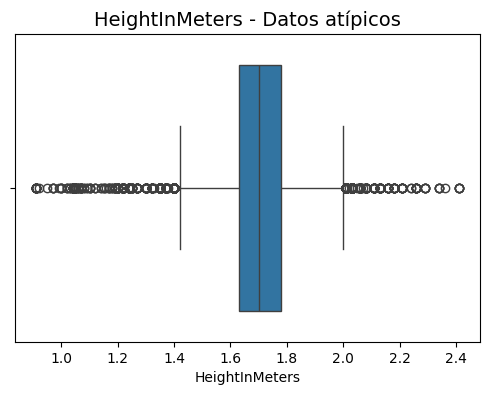

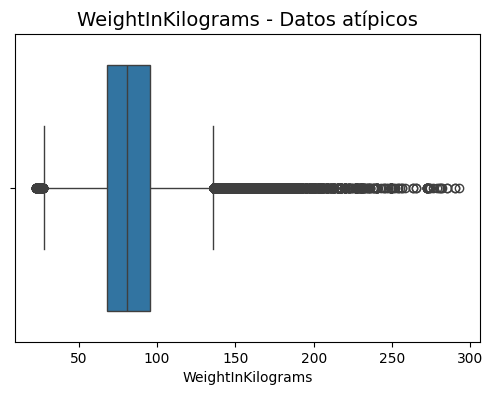

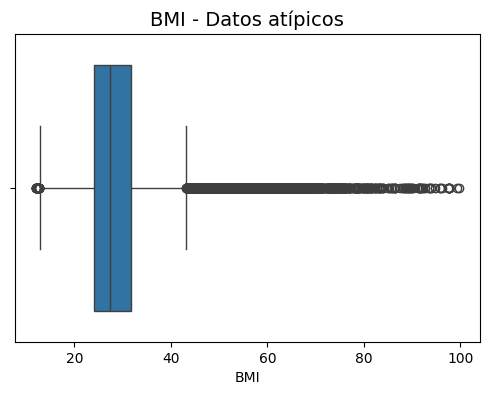

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que tienes tu DataFrame llamado 'df'
numerical_columns = [
    "PhysicalHealthDays", "MentalHealthDays", "SleepHours",
    "HeightInMeters", "WeightInKilograms", "BMI"
]

# Crear boxplots para cada columna numérica
for col in numerical_columns:
    plt.figure(figsize=(6, 4))  # Tamaño del gráfico
    sns.boxplot(x=df[col])
    plt.title(f'{col} - Datos atípicos', fontsize=14)
    plt.xlabel(col)
    plt.savefig(f"{col}_boxplot.png")  # Guarda la imagen
    plt.show()







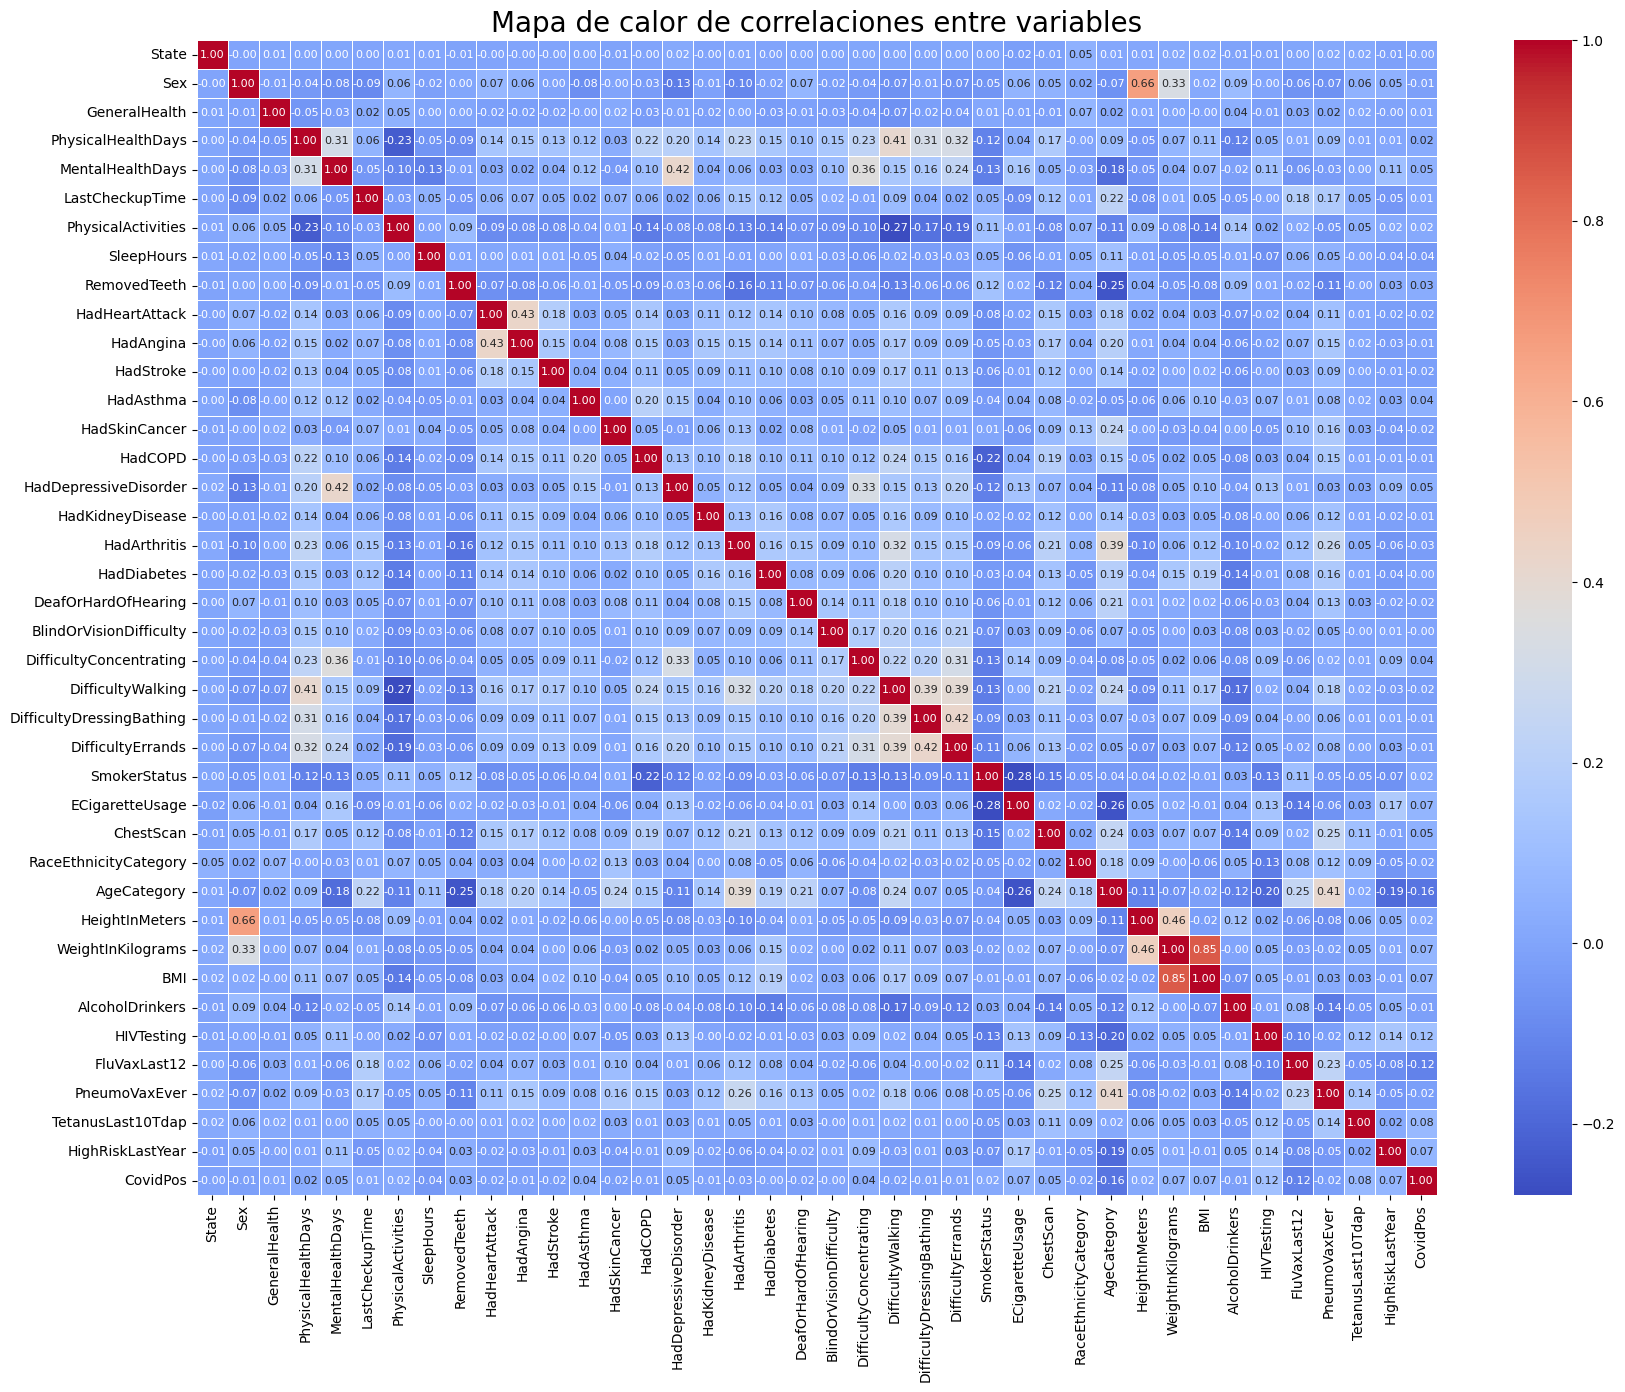

In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir variables categóricas a numéricas usando codificación ordinal
df_encoded = df_imputado.copy()

categorical_columns = [
    "State", "Sex", "GeneralHealth", "LastCheckupTime", "PhysicalActivities",
    "RemovedTeeth", "HadHeartAttack", "HadAngina", "HadStroke", "HadAsthma",
    "HadSkinCancer", "HadCOPD", "HadDepressiveDisorder", "HadKidneyDisease",
    "HadArthritis", "HadDiabetes", "DeafOrHardOfHearing", "BlindOrVisionDifficulty",
    "DifficultyConcentrating", "DifficultyWalking", "DifficultyDressingBathing",
    "DifficultyErrands", "SmokerStatus", "ECigaretteUsage", "ChestScan",
    "RaceEthnicityCategory", "AgeCategory", "AlcoholDrinkers", "HIVTesting",
    "FluVaxLast12", "PneumoVaxEver", "TetanusLast10Tdap", "HighRiskLastYear", "CovidPos"
]

for col in categorical_columns:
    df_encoded[col] = df_encoded[col].astype("category").cat.codes  # Asigna códigos numéricos a las categorías

# Calcular la matriz de correlación
corr_matrix = df_encoded.corr()

# Crear el heatmap con valores numéricos visibles y mayor tamaño
plt.figure(figsize=(20, 15))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    annot_kws={"size": 8}  # Reduce el tamaño de los números
)

# Configurar etiquetas
plt.xticks(rotation=90)  # Rotar etiquetas del eje X para mejor visualización
plt.yticks(rotation=0)   # Mantener las etiquetas del eje Y horizontales
plt.title("Mapa de calor de correlaciones entre variables", fontsize=20)

# Mostrar el heatmap
plt.show()



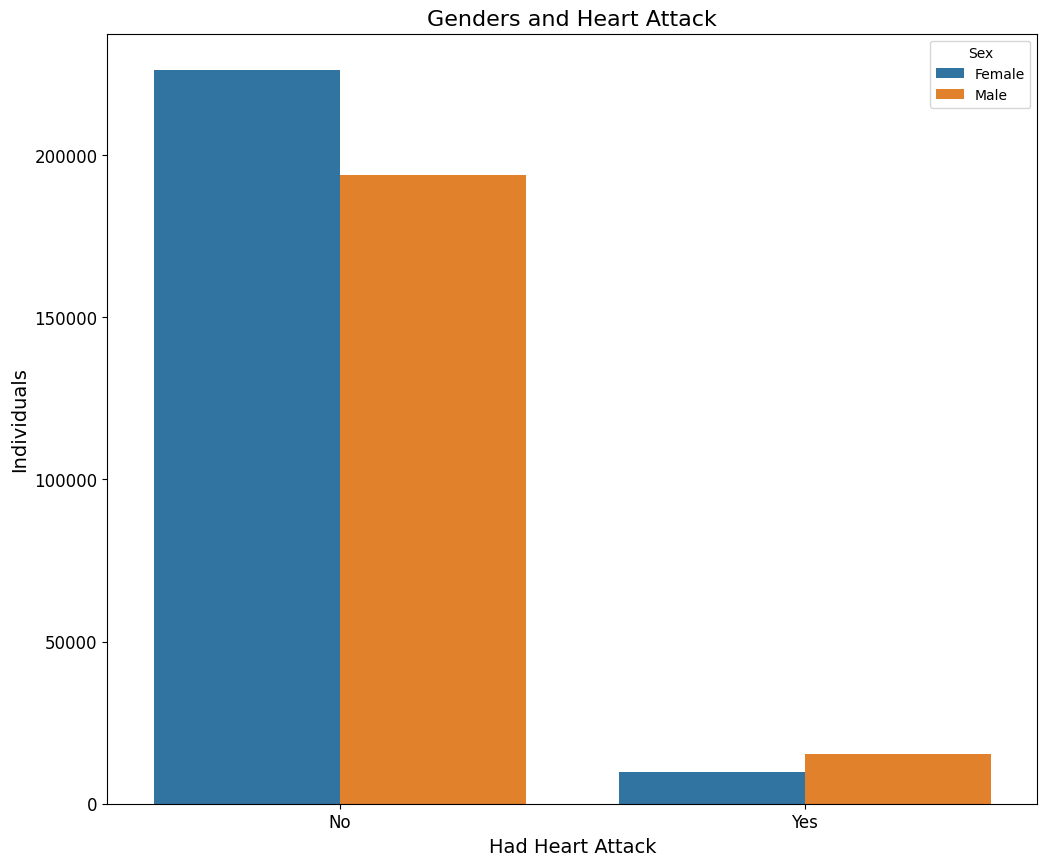

In [92]:
# Crear el gráfico de conteo con df_imputado
ax = sns.countplot(data=df_imputado, x='HadHeartAttack', hue='Sex')

# Función para personalizar el gráfico
def customize_plot(ax, title, xlabel, ylabel, width, height):
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.gcf().set_size_inches(width, height)  # Ajustar tamaño de la figura

# Aplicar la personalización
customize_plot(ax, "Genders and Heart Attack", "Had Heart Attack", "Individuals", 12, 10)

# Guardar el gráfico en un archivo
scatter_fig = ax.get_figure()
scatter_fig.savefig('genderHeartAttack.png', dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()

<ipython-input-93-786e45c8d5ae>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


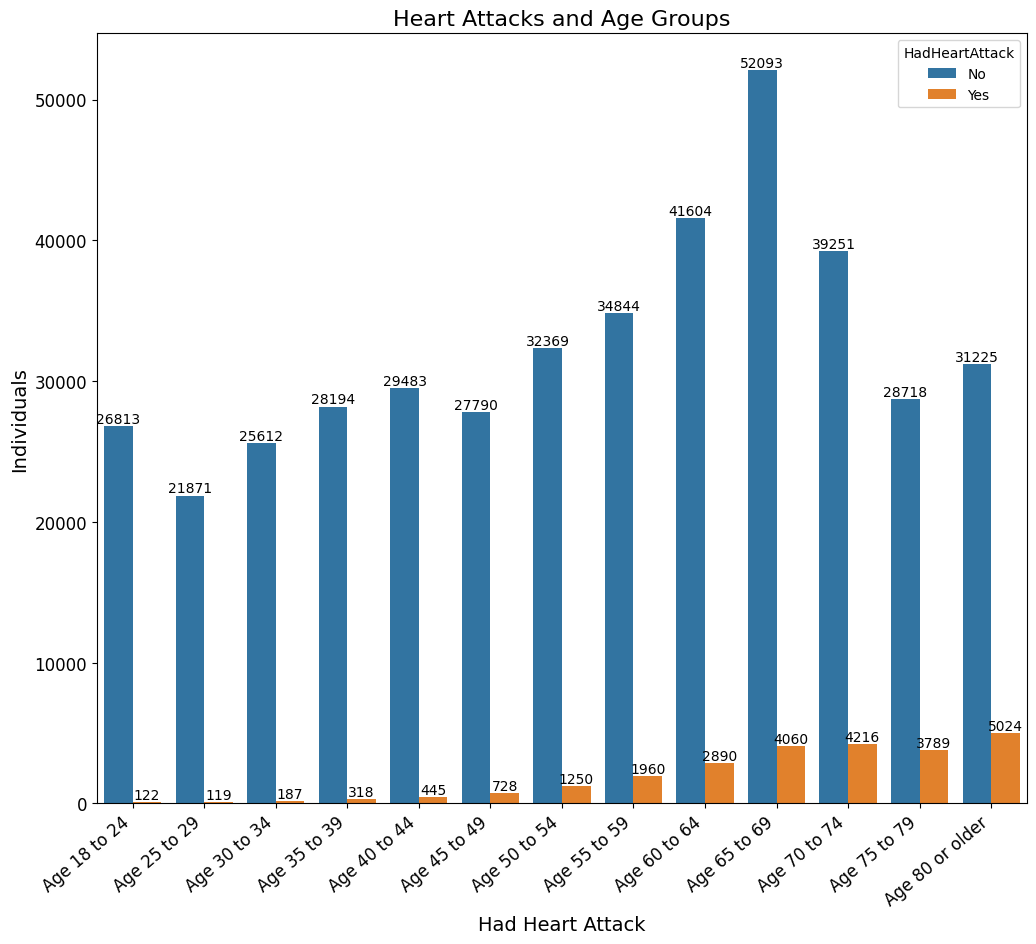

In [93]:
# Asegúrate de que 'AgeCategory' sea una columna categórica
df_imputado['AgeCategory'] = df_imputado['AgeCategory'].astype('category')

# Crear el gráfico de barras
ax = sns.countplot(data=df_imputado, x='AgeCategory', hue='HadHeartAttack')

# Rotar etiquetas del eje X para mejorar legibilidad
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

# Personalizar el gráfico
customize_plot(ax, "Heart Attacks and Age Groups", "Had Heart Attack", "Individuals", 12, 10)

# Añadir etiquetas a las barras
for c in ax.containers:
    ax.bar_label(c)

# Guardar el gráfico
scatter_fig = ax.get_figure()
scatter_fig.savefig('countplotByAge.png')

# Mostrar el gráfico
plt.show()

# **6) Árbol RandomForestClassifier**


In [94]:
df_imputado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 444975 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   State                      444975 non-null  object  
 1   Sex                        444975 non-null  object  
 2   GeneralHealth              444975 non-null  object  
 3   PhysicalHealthDays         444975 non-null  float64 
 4   MentalHealthDays           444975 non-null  float64 
 5   LastCheckupTime            444975 non-null  object  
 6   PhysicalActivities         444975 non-null  object  
 7   SleepHours                 444975 non-null  float64 
 8   RemovedTeeth               444975 non-null  object  
 9   HadHeartAttack             444975 non-null  object  
 10  HadAngina                  444975 non-null  object  
 11  HadStroke                  444975 non-null  object  
 12  HadAsthma                  444975 non-null  object  
 13  HadSkinCancer      

In [95]:
for col in df: # Verificar si hay una columna o atributo que no aporte, ejemplo si tiene 1 subnivel, no nos sirve
  print(f"Columna {col}: {df_imputado[col].nunique() } subniveles ")

Columna State: 54 subniveles 
Columna Sex: 2 subniveles 
Columna GeneralHealth: 5 subniveles 
Columna PhysicalHealthDays: 31 subniveles 
Columna MentalHealthDays: 31 subniveles 
Columna LastCheckupTime: 4 subniveles 
Columna PhysicalActivities: 2 subniveles 
Columna SleepHours: 24 subniveles 
Columna RemovedTeeth: 4 subniveles 
Columna HadHeartAttack: 2 subniveles 
Columna HadAngina: 2 subniveles 
Columna HadStroke: 2 subniveles 
Columna HadAsthma: 2 subniveles 
Columna HadSkinCancer: 2 subniveles 
Columna HadCOPD: 2 subniveles 
Columna HadDepressiveDisorder: 2 subniveles 
Columna HadKidneyDisease: 2 subniveles 
Columna HadArthritis: 2 subniveles 
Columna HadDiabetes: 4 subniveles 
Columna DeafOrHardOfHearing: 2 subniveles 
Columna BlindOrVisionDifficulty: 2 subniveles 
Columna DifficultyConcentrating: 2 subniveles 
Columna DifficultyWalking: 2 subniveles 
Columna DifficultyDressingBathing: 2 subniveles 
Columna DifficultyErrands: 2 subniveles 
Columna SmokerStatus: 4 subniveles 
Colum

In [96]:
# Obtener valores únicos de todas las columnas en df_imputado
for col in df_imputado.columns:
    print(f"\n Valores únicos en la columna {col}: {df_imputado[col].unique()}\n")



 Valores únicos en la columna State: ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming' 'Guam' 'Puerto Rico'
 'Virgin Islands']


 Valores únicos en la columna Sex: ['Female' 'Male']


 Valores únicos en la columna GeneralHealth: ['Very good' 'Excellent' 'Fair' 'Poor' 'Good']


 Valores únicos en la columna PhysicalHealthDays: [ 0.  2.  1.  8.  5. 30.  4. 23. 14. 15.  3. 10.  7. 25.  6. 21. 20. 29.
 16.  9. 27. 28. 12. 13. 11. 26. 17. 24. 19.

In [97]:
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.preprocessing import LabelEncoder

# # Crear el codificador
# le = LabelEncoder()

# # Lista de columnas binarias a convertir
# binary_columns = ['PhysicalActivities', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma',
#                   'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease',
#                   'HadArthritis', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
#                   'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing',
#                   'DifficultyErrands','Sex','HadDiabetes','AlcoholDrinkers']

# # Convertir las columnas binarias a 0 y 1
# for column in binary_columns:
#     df_imputado[column] = le.fit_transform(df_imputado[column])

# # Seleccionar las variables predictoras (X) y la variable objetivo (y)
# X = df_imputado[['PhysicalActivities', 'HadAngina', 'HadStroke', 'HadAsthma',
#                   'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease',
#                   'HadArthritis', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
#                   'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing',
#                   'DifficultyErrands','WeightInKilograms', 'HeightInMeters','BMI','Sex','SleepHours','HadDiabetes','AlcoholDrinkers']]

# y = df_imputado['HadHeartAttack']

# # Dividir el conjunto de datos en entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=87)

# # Crear y entrenar el modelo Random Forest
# rf_model = RandomForestClassifier(n_estimators=500, random_state=2002, max_depth=8, min_samples_split=2, min_samples_leaf=1, class_weight={0:1, 1:3})

# rf_model.fit(X_train, y_train)

# # Realizar predicciones
# y_pred = rf_model.predict(X_test)

# # Calcular las métricas de evaluación
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# # Imprimir las métricas
# print("Accuracy del modelo Random Forest:", accuracy)
# print("Precision del modelo Random Forest:", precision)
# print("Recall del modelo Random Forest:", recall)
# print("F1 Score del modelo Random Forest:", f1)

# # Mostrar la matriz de confusión
# conf_matrix = confusion_matrix(y_test, y_pred)

# plt.figure(figsize=(10, 7))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Heart Attack', 'Heart Attack'], yticklabels=['No Heart Attack', 'Heart Attack'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Matriz de Confusión')
# plt.show()



In [98]:
# # Seleccionar un árbol del modelo Random Forest
# import matplotlib.pyplot as plt
# from sklearn.tree import plot_tree
# tree = rf_model.estimators_[0]

# # Graficar el árbol con mejor visualización
# plt.figure(figsize=(60, 30), dpi=400)  # Aumenta el tamaño y la resolución
# plot_tree(tree,
#           filled=True,
#           feature_names=X.columns,
#           class_names=['No Heart Attack', 'Heart Attack'],
#           rounded=True,
#           fontsize=25,  # Reduce la fuente para evitar superposición
#           max_depth=3)  # Limita la profundidad del árbol
# plt.title('Árbol de Decisión del Modelo Random Forest', fontsize=18)
# plt.show()


In [99]:
# columnas_faltantes = set(df_imputado.columns) - set(X) # Columnas que me faltan agregar

# print(columnas_faltantes)


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value

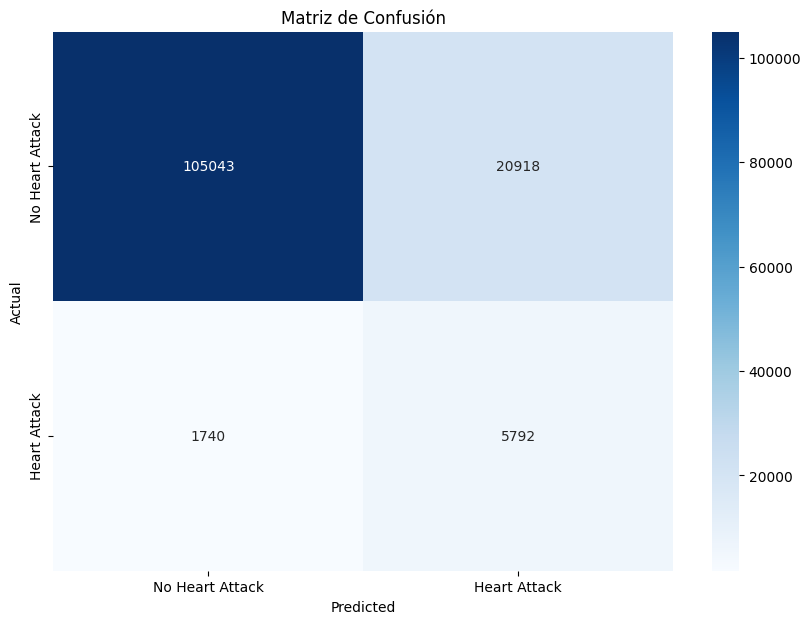

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


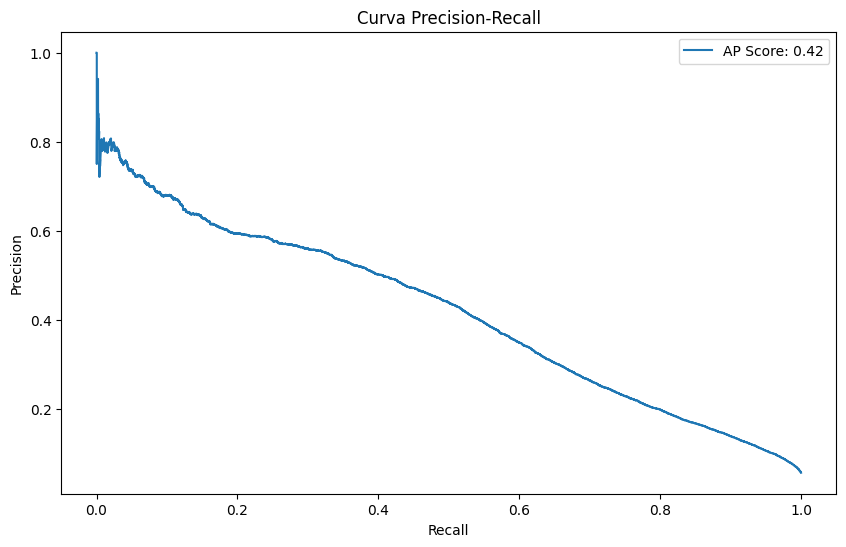

In [105]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparación de Datos
# --------------------------------------------------
target_column = "HadHeartAttack"

# Convertir la variable objetivo a categórica directamente
df_imputado[target_column] = df_imputado[target_column].astype('category')

# Definir variables predictoras (X) y la variable objetivo (y)
X = df_imputado.drop(columns=[target_column])
y = df_imputado[target_column]  # Mantenemos como categoría

# Identificar columnas categóricas en X
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
X[categorical_columns] = X[categorical_columns].astype('category')

# 2. División de Datos
# --------------------------------------------------
# Dividir manteniendo las categorías originales
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=87, stratify=y
)

# 3. Configuración y Entrenamiento del Modelo
# --------------------------------------------------
lgb_model = lgb.LGBMClassifier(
    boosting_type='goss',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=-1,
    num_leaves=63,
    min_data_in_leaf=30,
    feature_fraction=0.8,
    lambda_l1=0.1,
    lambda_l2=0.1,
    class_weight='balanced',
    random_state=42,
    objective='binary',  # Asegurar que es para clasificación binaria
    metric='binary_logloss'
)

# Entrenamiento con early stopping (una sola vez)
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='binary_logloss',
    categorical_feature=categorical_columns,
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# 4. Predicción y Evaluación
# --------------------------------------------------
# Realizar predicciones (ya están en las categorías originales)
y_pred = lgb_model.predict(X_test)

# Calcular métricas directamente con las categorías
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Yes')
recall = recall_score(y_test, y_pred, pos_label='Yes')
f1 = f1_score(y_test, y_pred, pos_label='Yes')

# Imprimir métricas
print("\nMétricas de Evaluación:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# 5. Visualización
# --------------------------------------------------
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Heart Attack', 'Heart Attack'],
            yticklabels=['No Heart Attack', 'Heart Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

# Curva Precision-Recall (Opcional)
from sklearn.metrics import precision_recall_curve, average_precision_score
y_probs = lgb_model.predict_proba(X_test)[:, 1]
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_probs, pos_label='Yes')
ap_score = average_precision_score(y_test, y_probs, pos_label='Yes')

plt.figure(figsize=(10, 6))
plt.plot(recall_curve, precision_curve, label=f'AP Score: {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.show()

# **Mal Rendimiento**
Como el rendimiento no es tan bueno, ajustaremos el dataset conservando solo las columnas relevantes, ya que las demás están afectando negativamente el rendimiento

In [107]:
columnas_a_eliminar = [
    'State',  # Ubicación geográfica no es un factor médico directo
    'DeafOrHardOfHearing',  # Problemas auditivos no relacionados
    'BlindOrVisionDifficulty',  # Problemas visuales no relacionados
    'HIVTesting',  # No directamente relacionado con salud cardíaca
    'RemovedTeeth',  # Salud dental no es predictor cardíaco
    'ChestScan',  # Es un examen, no un factor de riesgo
    'FluVaxLast12',  # Vacuna de gripe no es relevante
    'PneumoVaxEver',  # Vacuna neumococo no es relevante
    'CovidPos',  # Muy reciente para tener datos concluyentes
    'HeightInMeters',  # Mejor usar BMI que combina altura/peso
    'WeightInKilograms',  # Mejor usar BMI
    'DifficultyConcentrating',  # Síntoma muy genérico
    'DifficultyDressingBathing',  # Movilidad no específica cardíaca
    'DifficultyErrands'  # Movilidad no específica cardíaca
]


variables_clave = [
    # Factores demográficos básicos
    'Sex',
    'AgeCategory',

    # Salud general
    'GeneralHealth',
    'PhysicalHealthDays',
    'MentalHealthDays',
    'BMI',

    # Factores de riesgo cardiovascular
    'HadAngina',
    'HadStroke',
    'HadAsthma',
    'HadCOPD',
    'HadDiabetes',
    'HadKidneyDisease',
    'HadArthritis',

    # Hábitos de vida
    'SmokerStatus',
    'ECigaretteUsage',
    'AlcoholDrinkers',
    'PhysicalActivities',
    'SleepHours',

    # Comorbilidades relevantes
    'HadDepressiveDisorder',
    'HadSkinCancer',  # Algunos estudios muestran correlación

    # Exámenes médicos
    'LastCheckupTime',
    'HighRiskLastYear',

    # Dificultades físicas relacionadas
    'DifficultyWalking'  # Puede indicar problemas circulatorios
]

# Intento 1 ) Sin columnas relevantes con parametros 1

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value

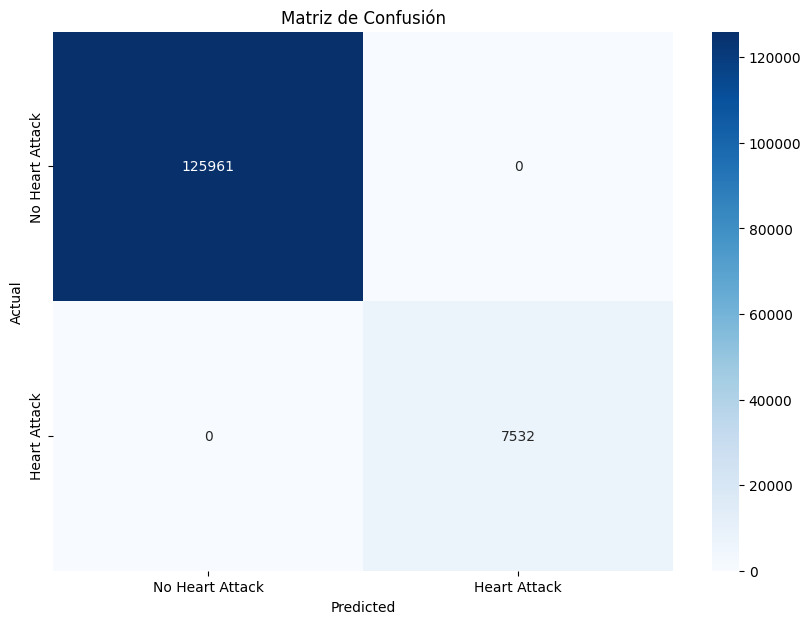

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


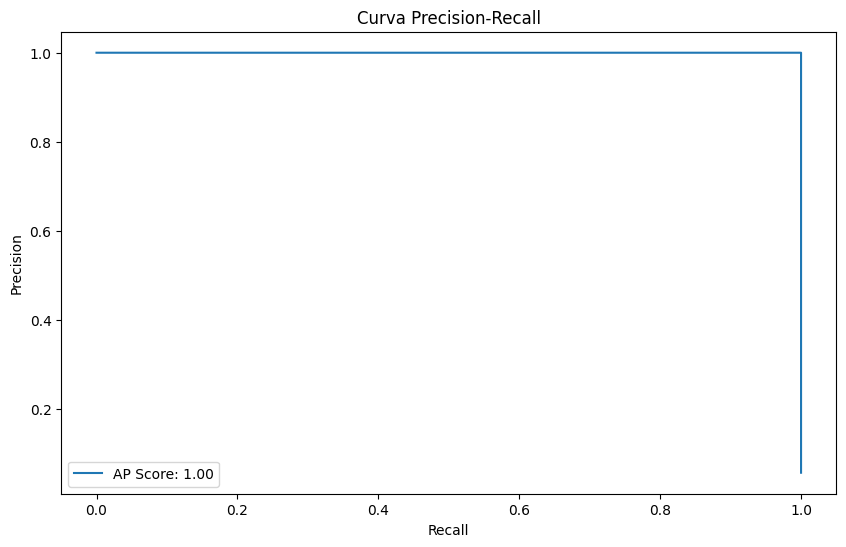

In [108]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparación de Datos
# --------------------------------------------------
target_column = "HadHeartAttack"

# Convertir la variable objetivo a categórica directamente
df_imputado[target_column] = df_imputado[target_column].astype('category')

# Definir variables predictoras (X) y la variable objetivo (y)
X = df_imputado.drop(columns=[target_column]) # Elimino la columna objetivo de la X
X = df_imputado.drop(columns=columnas_a_eliminar) # elimino las columnas que considero poco utiles
y = df_imputado[target_column]  # Mantenemos como categoría

# Identificar columnas categóricas en X
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
X[categorical_columns] = X[categorical_columns].astype('category')

# 2. División de Datos
# --------------------------------------------------
# Dividir manteniendo las categorías originales
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=87, stratify=y
)

# 3. Configuración y Entrenamiento del Modelo
# --------------------------------------------------
lgb_model = lgb.LGBMClassifier(
    boosting_type='goss',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=-1,
    num_leaves=63,
    min_data_in_leaf=30,
    feature_fraction=0.8,
    lambda_l1=0.1,
    lambda_l2=0.1,
    class_weight='balanced',
    random_state=42,
    objective='binary',  # Asegurar que es para clasificación binaria
    metric='binary_logloss'
)

# Entrenamiento con early stopping (una sola vez)
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='binary_logloss',
    categorical_feature=categorical_columns,
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# 4. Predicción y Evaluación
# --------------------------------------------------
# Realizar predicciones (ya están en las categorías originales)
y_pred = lgb_model.predict(X_test)

# Calcular métricas directamente con las categorías
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Yes')
recall = recall_score(y_test, y_pred, pos_label='Yes')
f1 = f1_score(y_test, y_pred, pos_label='Yes')

# Imprimir métricas
print("\nMétricas de Evaluación:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# 5. Visualización
# --------------------------------------------------
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Heart Attack', 'Heart Attack'],
            yticklabels=['No Heart Attack', 'Heart Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

# Curva Precision-Recall (Opcional)
from sklearn.metrics import precision_recall_curve, average_precision_score
y_probs = lgb_model.predict_proba(X_test)[:, 1]
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_probs, pos_label='Yes')
ap_score = average_precision_score(y_test, y_probs, pos_label='Yes')

plt.figure(figsize=(10, 6))
plt.plot(recall_curve, precision_curve, label=f'AP Score: {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.show()

# Intento 2 ) Sin columnas relevantes con parametros 2

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.3, reg_lambda=0.0 will be ignored. Current value

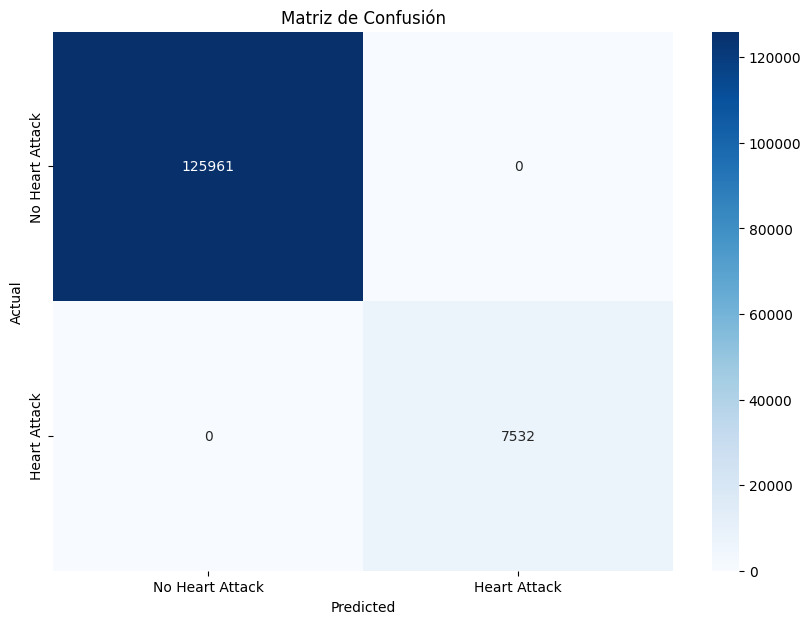

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0.3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


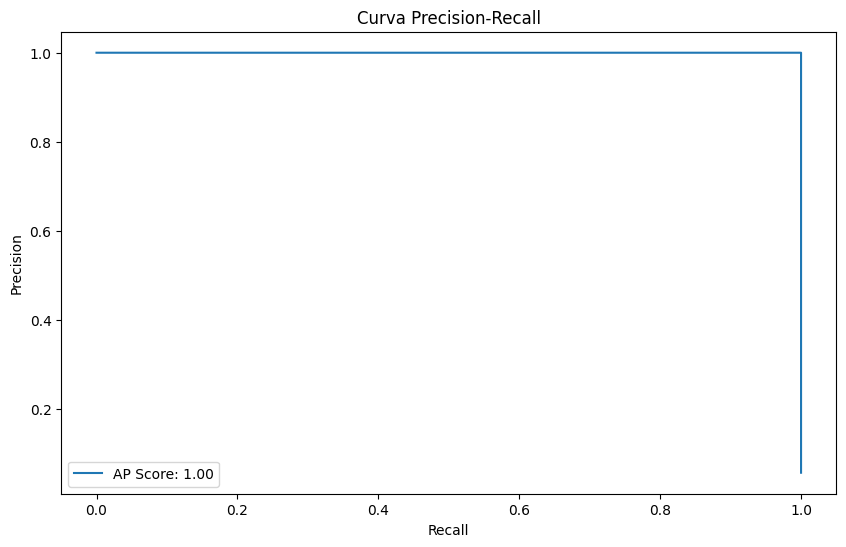

In [110]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparación de Datos
# --------------------------------------------------
target_column = "HadHeartAttack"

# Convertir la variable objetivo a categórica directamente
df_imputado[target_column] = df_imputado[target_column].astype('category')

# Definir variables predictoras (X) y la variable objetivo (y)
X = df_imputado.drop(columns=[target_column]) # Elimino la columna objetivo de la X
X = df_imputado.drop(columns=columnas_a_eliminar) # elimino las columnas que considero poco utiles
y = df_imputado[target_column]  # Mantenemos como categoría

# Identificar columnas categóricas en X
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
X[categorical_columns] = X[categorical_columns].astype('category')

# 2. División de Datos
# --------------------------------------------------
# Dividir manteniendo las categorías originales
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=87, stratify=y
)

# 3. Configuración y Entrenamiento del Modelo
# --------------------------------------------------
lgb_model = lgb.LGBMClassifier(
    boosting_type='goss',
    n_estimators=500,  # Reducido para evitar overfitting
    learning_rate=0.05,
    max_depth=7,       # Limitado
    num_leaves=31,
    min_data_in_leaf=50,
    feature_fraction=0.7,
    lambda_l1=0.3,    # Más regularización
    lambda_l2=0.3,
    class_weight='balanced',
    random_state=42,
    objective='binary',
    metric='aucpr'     # Métrica robusta para clases desbalanceadas

)

# Entrenamiento con early stopping (una sola vez)
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='binary_logloss',
    categorical_feature=categorical_columns,
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# 4. Predicción y Evaluación
# --------------------------------------------------
# Realizar predicciones (ya están en las categorías originales)
y_pred = lgb_model.predict(X_test)

# Calcular métricas directamente con las categorías
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Yes')
recall = recall_score(y_test, y_pred, pos_label='Yes')
f1 = f1_score(y_test, y_pred, pos_label='Yes')

# Imprimir métricas
print("\nMétricas de Evaluación:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# 5. Visualización
# --------------------------------------------------
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Heart Attack', 'Heart Attack'],
            yticklabels=['No Heart Attack', 'Heart Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

# Curva Precision-Recall (Opcional)
from sklearn.metrics import precision_recall_curve, average_precision_score
y_probs = lgb_model.predict_proba(X_test)[:, 1]
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_probs, pos_label='Yes')
ap_score = average_precision_score(y_test, y_probs, pos_label='Yes')

plt.figure(figsize=(10, 6))
plt.plot(recall_curve, precision_curve, label=f'AP Score: {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.show()

# Intento 3 ) Sin columnas relevantes con parametros simples 3   

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=5. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=5. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 17576, number of negative: 293906
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 311482, number of used features: 26
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=5. Current value: min_data_in_leaf=5
[LightGBM] [War

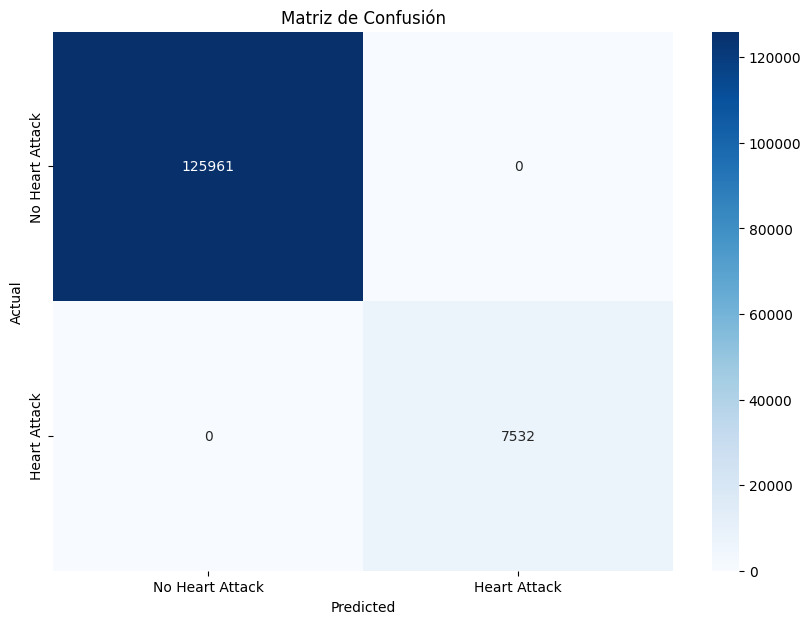

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=5. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Unknown parameter: min_samples_split


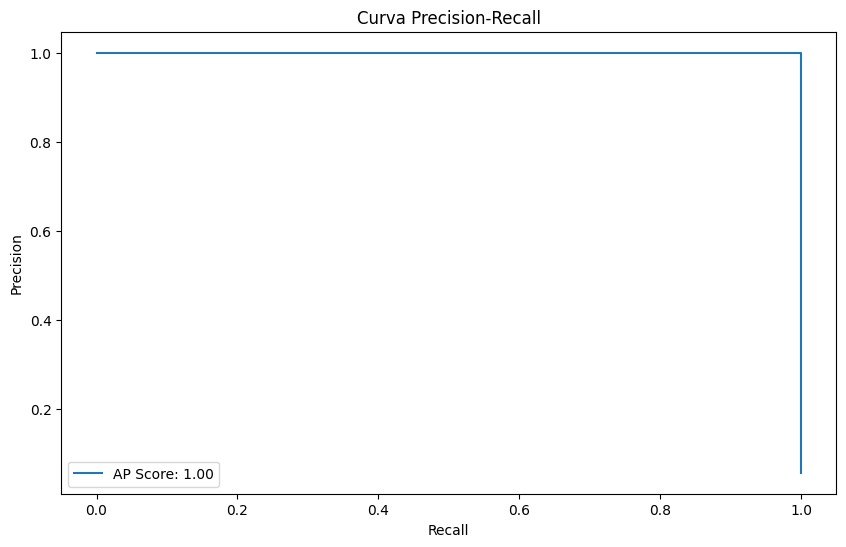

In [111]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparación de Datos
# --------------------------------------------------
target_column = "HadHeartAttack"

# Convertir la variable objetivo a categórica directamente
df_imputado[target_column] = df_imputado[target_column].astype('category')

# Definir variables predictoras (X) y la variable objetivo (y)
X = df_imputado.drop(columns=[target_column]) # Elimino la columna objetivo de la X
X = df_imputado.drop(columns=columnas_a_eliminar) # elimino las columnas que considero poco utiles
y = df_imputado[target_column]  # Mantenemos como categoría

# Identificar columnas categóricas en X
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
X[categorical_columns] = X[categorical_columns].astype('category')

# 2. División de Datos
# --------------------------------------------------
# Dividir manteniendo las categorías originales
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=87, stratify=y
)

# 3. Configuración y Entrenamiento del Modelo
# --------------------------------------------------
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,      # Número de árboles (mantenlo moderado)
    max_depth=5,           # Profundidad máxima de los árboles (evita overfitting)
    min_samples_split=10,   # Mínimo de muestras para dividir un nodo
    min_samples_leaf=5,     # Mínimo de muestras en nodos hoja
    class_weight='balanced', # Manejo automático de clases desbalanceadas
    random_state=42,        # Para reproducibilidad
    n_jobs=-1              # Usa todos los núcleos del procesador
)

# Entrenamiento con early stopping (una sola vez)
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='binary_logloss',
    categorical_feature=categorical_columns,
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# 4. Predicción y Evaluación
# --------------------------------------------------
# Realizar predicciones (ya están en las categorías originales)
y_pred = lgb_model.predict(X_test)

# Calcular métricas directamente con las categorías
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Yes')
recall = recall_score(y_test, y_pred, pos_label='Yes')
f1 = f1_score(y_test, y_pred, pos_label='Yes')

# Imprimir métricas
print("\nMétricas de Evaluación:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# 5. Visualización
# --------------------------------------------------
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Heart Attack', 'Heart Attack'],
            yticklabels=['No Heart Attack', 'Heart Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

# Curva Precision-Recall (Opcional)
from sklearn.metrics import precision_recall_curve, average_precision_score
y_probs = lgb_model.predict_proba(X_test)[:, 1]
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_probs, pos_label='Yes')
ap_score = average_precision_score(y_test, y_probs, pos_label='Yes')

plt.figure(figsize=(10, 6))
plt.plot(recall_curve, precision_curve, label=f'AP Score: {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.show()

In [113]:
X

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,HadHeartAttack,HadAngina,HadStroke,...,HadDiabetes,DifficultyWalking,SmokerStatus,ECigaretteUsage,RaceEthnicityCategory,AgeCategory,BMI,AlcoholDrinkers,TetanusLast10Tdap,HighRiskLastYear
0,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,No,No,No,...,Yes,No,Never smoked,Not at all (right now),"White only, Non-Hispanic",Age 80 or older,27.44,No,"Yes, received tetanus shot but not sure what type",No
1,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,No,6.0,No,No,No,...,No,No,Never smoked,Never used e-cigarettes in my entire life,"White only, Non-Hispanic",Age 80 or older,26.57,No,"No, did not receive any tetanus shot in the pa...",No
2,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,No,No,No,...,No,No,Never smoked,Never used e-cigarettes in my entire life,"White only, Non-Hispanic",Age 55 to 59,25.61,No,"No, did not receive any tetanus shot in the pa...",No
3,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,No,No,No,...,No,No,Current smoker - now smokes some days,Never used e-cigarettes in my entire life,"White only, Non-Hispanic",Age 65 to 69,23.30,No,"No, did not receive any tetanus shot in the pa...",No
4,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,No,No,No,...,No,No,Never smoked,Never used e-cigarettes in my entire life,"White only, Non-Hispanic",Age 40 to 44,21.77,Yes,"No, did not receive any tetanus shot in the pa...",No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445127,Female,Good,0.0,3.0,Within past 2 years (1 year but less than 2 ye...,Yes,6.0,No,No,No,...,No,No,Never smoked,Never used e-cigarettes in my entire life,"Black only, Non-Hispanic",Age 18 to 24,25.63,Yes,"No, did not receive any tetanus shot in the pa...",No
445128,Female,Excellent,2.0,2.0,Within past year (anytime less than 12 months ...,Yes,7.0,No,No,No,...,No,No,Never smoked,Never used e-cigarettes in my entire life,"Black only, Non-Hispanic",Age 50 to 54,28.66,No,"Yes, received tetanus shot but not sure what type",No
445129,Female,Poor,30.0,30.0,5 or more years ago,No,5.0,No,No,No,...,No,No,Current smoker - now smokes every day,Use them some days,"White only, Non-Hispanic",Age 65 to 69,17.23,Yes,"No, did not receive any tetanus shot in the pa...",No
445130,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,5.0,Yes,No,No,...,No,No,Never smoked,Never used e-cigarettes in my entire life,"Black only, Non-Hispanic",Age 70 to 74,32.55,No,"No, did not receive any tetanus shot in the pa...",No


,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,HadHeartAttack,HadAngina,HadStroke,...,HadDiabetes,DifficultyWalking,SmokerStatus,ECigaretteUsage,RaceEthnicityCategory,AgeCategory,BMI,AlcoholDrinkers,TetanusLast10Tdap,HighRiskLastYear
0,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,No,No,No,...,Yes,No,Never smoked,Not at all (right now),"White only, Non-Hispanic",Age 80 or older,27.44,No,"Yes, received tetanus shot but not sure what type",No
1,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,No,6.0,No,No,No,...,No,No,Never smoked,Never used e-cigarettes in my entire life,"White only, Non-Hispanic",Age 80 or older,26.57,No,"No, did not receive any tetanus shot in the pa...",No
2,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,No,No,No,...,No,No,Never smoked,Never used e-cigarettes in my entire life,"White only, Non-Hispanic",Age 55 to 59,25.61,No,"No, did not receive any tetanus shot in the pa...",No
3,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,No,No,No,...,No,No,Current smoker - now smokes some days,Never used e-cigarettes in my entire life,"White only, Non-Hispanic",Age 65 to 69,23.30,No,"No, did not receive any tetanus shot in the pa...",No
4,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,No,No,No,...,No,No,Never smoked,Never used e-cigarettes in my entire life,"White only, Non-Hispanic",Age 40 to 44,21.77,Yes,"No, did not receive any tetanus shot in the pa...",No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445127,Female,Good,0.0,3.0,Within past 2 years (1 year but less than 2 ye...,Yes,6.0,No,No,No,...,No,No,Never smoked,Never used e-cigarettes in my entire life,"Black only, Non-Hispanic",Age 18 to 24,25.63,Yes,"No, did not receive any tetanus shot in the pa...",No
445128,Female,Excellent,2.0,2.0,Within past year (anytime less than 12 months ...,Yes,7.0,No,No,No,...,No,No,Never smoked,Never used e-cigarettes in my entire life,"Black only, Non-Hispanic",Age 50 to 54,28.66,No,"Yes, received tetanus shot but not sure what type",No
445129,Female,Poor,30.0,30.0,5 or more years ago,No,5.0,No,No,No,...,No,No,Current smoker - now smokes every day,Use them some days,"White only, Non-Hispanic",Age 65 to 69,17.23,Yes,"No, did not receive any tetanus shot in the pa...",No
445130,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,5.0,Yes,No,No,...,No,No,Never smoked,Never used e-cigarettes in my entire life,"Black only, Non-Hispanic",Age 70 to 74,32.55,No,"No, did not receive any tetanus shot in the pa...",No
